# Wind Farm Analysis

## Introduction to the Data

The weather [data](https://www.met.ie/climate/available-data/historical-data) used in this project was sourced from Met Éireann, the Irish Meteorological Service. I wanted wind speed data so I had to look at each weather station's dataset to see if it had a windspeed column. This seemed endless as there were so many, until I realised that only the bigger weather stations measured windspeed and only these ones collected hourly data - which I could filter by. I ended up with 18 datasets. The goal was to ensure comprehensive coverage of significant geographical areas.

Each station’s data was provided as a separate CSV file, and each file was contained within its own folder alongside metadata and licensing information. This meant I had to unzip and organise the files before processing them, which took forever. After that I tried to automate as much of the data handling that I could.

In [1]:
# Importing libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('data/hly275/hly275.csv', skiprows = 17, low_memory=False)
print(df.head())
df.info()

                date  ind rain  ind.1 temp  ind.2 wetb dewpt vappr rhum msl  \
0  13-aug-2003 01:00   -1           4           4                             
1  13-aug-2003 02:00   -1           4           4                             
2  13-aug-2003 03:00   -1           4           4                             
3  13-aug-2003 04:00   -1           4           4                             
4  13-aug-2003 05:00   -1           4           4                             

   ind.3 wdsp  ind.4 wddir  
0      7           7        
1      7           7        
2      7           7        
3      7           7        
4      7           7        
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186744 entries, 0 to 186743
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    186744 non-null  object
 1   ind     186744 non-null  int64 
 2   rain    186744 non-null  object
 3   ind.1   186744 non-null  int64 
 4   temp    18674

## Automating Skipping Metadata

The weather datasets I’m working with include metadata at the top, with the actual data starting on different rows in each file. Manually checking which row the header starts on for every file and then using `skiprows` would take ages and isn’t practical.

To automate this, I wrote a function that detects the header row automatically. It looks for specific keywords ('date' and 'wdsp') that always appear in the header column names and don't appear together on a row in the metadata. Once it finds the right row, it skips all the metadata and reads the data directly from the header onwards. This also confirmed that all the datasets had a windspeed column. This [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) helped.

Another issue I had was the name of the weather station is contained in the metadata. This information is essential for analysis, but it isn’t part of the main data table. I needed a way to extract the station name from the metadata and add it as a column in the dataset. I wasn't going to do this manually.

So I wrote a function to extract the station name from the metadata. Each file contains a line like: `Station Name: MACE HEAD` at the start, so the function [searches for that specific line](https://www.statology.org/pandas-query-startswith/) and [grabs the station name](https://www.w3schools.com/python/ref_string_split.asp). To ensure consistency, the name is converted to uppercase and added as a new column `station` in the cleaned dataset. This process ensures that each row of data is tagged with the correct station name for future analysis.


In [3]:
def detect_header_row(file_path):
    """
    Detects the row number where the header starts based on the presence of 'date' and 'wdsp'.
    """
    row_number = 0  # Start counting rows
    with open(file_path, 'r') as file:
        for line in file:  # Read the file line by line
            if "date" in line.lower() and "wdsp" in line.lower(): # .lower makes it case insensitve just in case
                return row_number  # Return the current row number as the header row. This is the row number I can use for skiprows in fucntion below
            row_number += 1  # row counter goes up by one
    return None  # Return None if no valid header is found


def extract_station_name(file_path):
    """
    Extracts the station name from the first line of each csv file that starts with 'Station Name:'.
    """
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("Station Name:"):
                # Extract the part after "Station Name:" and strip any whitespace
                return line.split("Station Name:")[1].strip().upper()  # Ensure the name is uppercase
    return None  # Return None if no station name is found


def read_clean_csv(file_path):
    """
    Reads a CSV file, skips metadata rows, and adds a 'station' column.
    """
    # Extract the station name from the metadata
    station_name = extract_station_name(file_path)

    # Detect the header row
    header_row = detect_header_row(file_path)
    if header_row is None:
        raise ValueError(f"No valid header found in {file_path}")

    # Read the data starting from the header row
    df = pd.read_csv(file_path, skiprows=header_row, low_memory=False)
    
    # Add Station Name as a column
    df['station'] = station_name
    return df


Testing fucntions with one of the files:

In [4]:
file_path = "data/hly275/hly275.csv"  # Replace with the path to one of your files

station_name = extract_station_name(file_path)
print(f"Extracted Station Name: {station_name}")

header_row = detect_header_row(file_path)
print(f"Detected Header Row: {header_row}")

cleaned_data = read_clean_csv(file_path)
print(cleaned_data.head())


Extracted Station Name: MACE HEAD
Detected Header Row: 17
                date  ind rain  ind.1 temp  ind.2 wetb dewpt vappr rhum msl  \
0  13-aug-2003 01:00   -1           4           4                             
1  13-aug-2003 02:00   -1           4           4                             
2  13-aug-2003 03:00   -1           4           4                             
3  13-aug-2003 04:00   -1           4           4                             
4  13-aug-2003 05:00   -1           4           4                             

   ind.3 wdsp  ind.4 wddir    station  
0      7           7        MACE HEAD  
1      7           7        MACE HEAD  
2      7           7        MACE HEAD  
3      7           7        MACE HEAD  
4      7           7        MACE HEAD  


## Making one Big Dataset

So it looks like the functions work!

I wanted to run the functions with each of the 18 CSV files I had. So I needed to create a list with each of the file paths. But I didn't want to do this manually. The [glob module](https://docs.python.org/3/library/glob.html) helped out here. I was able to search the data directory for the CSV files, and it even searched subdirectories within the data directory using its recursive search function [the `**` pattern](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/). So I could keep each CSV file in its own folder alongside its licence and other metadata.

In [5]:
import glob

# The directory I want to seach and also its subdirectories
data_path = "data/**/*.csv"  

# Get a list of all CSV files in the directory and its subdirectories
file_list = glob.glob(data_path, recursive=True)

print(file_list)  # Check the list of file paths
print(f"Number of files found: {len(file_list)}") # Checking I got all of them



['data\\hly1075\\hly1075.csv', 'data\\hly1175\\hly1175.csv', 'data\\hly1375\\hly1375.csv', 'data\\hly1475\\hly1475.csv', 'data\\hly1575\\hly1575.csv', 'data\\hly1775\\hly1775.csv', 'data\\hly1875\\hly1875.csv', 'data\\hly1975\\hly1975.csv', 'data\\hly2075\\hly2075.csv', 'data\\hly2175\\hly2175.csv', 'data\\hly2275\\hly2275.csv', 'data\\hly2375\\hly2375.csv', 'data\\hly275\\hly275.csv', 'data\\hly375\\hly375.csv', 'data\\hly575\\hly575.csv', 'data\\hly675\\hly675.csv', 'data\\hly775\\hly775.csv', 'data\\hly875\\hly875.csv']
Number of files found: 18


The next bit of code processes all the weather station files in the `file_list` by running each through the `read_clean_csv` function, which skips metadata and adds a `station` column to identify the source. The processed DataFrames are stored in the `all_data` list and then combined into a single dataset using [concat](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#concatenating-objects), creating `my_big_dataset` with all the data in one place. I ensured there would be a continuous index with the `ignore_index=True` parameter. 

Finally, the code checks the number of processed files by counting the entries in `all_data`, confirming that all files were successfully handled.


In [6]:
# Process each file in the file_list using the read_clean_csv function
all_data = [read_clean_csv(file) for file in file_list]

# Combine all processed DataFrames into one
my_big_dataset = pd.concat(all_data, ignore_index=True,)

# Checking all 18 files were processed
print(f"Number of processed files: {len(all_data)}")

#Saving as CSV file and checking it was saved
my_big_dataset.to_csv("my_big_dataset.csv", index=False)
print("Dataset saved as 'my_big_dataset.csv'")


Number of processed files: 18
Dataset saved as 'my_big_dataset.csv'


## Cleaning My Big Dataset

I ended up with a dataset that had over 5 million rows. So I printed it out and sat down at the kitchen table with a pencil and ruler so I could check each row for any issues. Just kidding! I didn't do that. Instead I used some handy code to figure out what kind of data I was dealing with.

In [7]:
print(my_big_dataset)

# Checking the structure of the data
print(my_big_dataset.info())

# Check for missing values
print(my_big_dataset.isnull().sum())


                      date  ind rain  ind.1  temp  ind.2  wetb dewpt vappr  \
0        01-dec-1955 01:00    0  0.0      0  10.7      0  10.0   9.4  11.8   
1        01-dec-1955 02:00    0  2.9      0   9.8      0   9.7  10.0  12.0   
2        01-dec-1955 03:00    0  3.8      0   9.7      0   9.5   9.4  11.7   
3        01-dec-1955 04:00    0  0.8      0   9.8      0   9.7   9.4  11.9   
4        01-dec-1955 05:00    0  0.3      0   8.9      0   8.7   8.3  11.1   
...                    ...  ...  ...    ...   ...    ...   ...   ...   ...   
5745370  30-nov-2024 20:00    0  0.0      0  13.5      0  12.7  12.0  14.0   
5745371  30-nov-2024 21:00    0  0.0      0  13.5      0  12.7  12.0  14.0   
5745372  30-nov-2024 22:00    0  4.1      0  12.1      0  11.7  11.4  13.5   
5745373  30-nov-2024 23:00    0  0.0      0  12.3      0  11.9  11.6  13.7   
5745374  01-dec-2024 00:00    0  0.0      0  12.3      0  11.8  11.4  13.4   

        rhum  ... wdsp  ind.4 wddir       station   ww    w  su

### Cleaning Up Missing Values

I focused on cleaning up the missing values in the dataset. Most of the original datasets had 16 columns, but a few included 5 additional columns. This introduced missing values when the datasets were merged, so it made sense that the last five columns had nearly 4 million missing values. Fortunately, `pandas.concat` [automatically converted](https://pyimagesearch.com/2024/05/07/using-pandas-concat-pd-concat/) these blanks into proper missing values (`NaN`), which were easy to handle during analysis.

However, when I inspected the other columns, `pandas` was reporting 0 missing values, which didn’t match what I saw when scrolling through `my_big_dataset.csv`. The issue was that some missing values were misrepresented as empty strings. They weren’t being recognised as missing values but as blank text, and this would cause problems during analysis. 

Another related issue was that most of the columns containing integers were [being read as `object` type](https://www.geeksforgeeks.org/pandas-detect-mixed-data-types-and-fix-it/). This might have happened because `pandas` was trying to handle the mix of integers and empty strings in those columns. 

To fix this, I wanted to replace all empty strings with `NaN` using [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html). But I needed to find out first how exactly the missing values were being represented.


In [8]:
# Check unique values in a column
print(my_big_dataset['wdsp'].unique())

['16' '11' '9' '5' '12' '15' '13' '14' '7' '4' '3' '6' '1' '0' '21' '19'
 '23' '22' '20' '8' '2' '17' '18' '10' '25' '29' '26' '24' '27' '28' '30'
 '31' '36' '32' '33' '34' '40' '41' '42' '38' '35' '46' '48' '44' '37'
 '39' '43' '47' '50' '53' '54' '45' '51' '55' '49' '52' '59' '56' ' ' '62'
 '60' '57' '63' '61' '58' '97']


So the missing values were being represented as " "

In [9]:
# Replace all empty strings with NaN in the dataset
my_big_dataset.replace(" ", np.nan, inplace=True)

# Verify the change by checking for missing values
print(my_big_dataset.isnull().sum())
print(my_big_dataset.info())

date             0
ind              0
rain        110833
ind.1            0
temp         30409
ind.2            0
wetb         42486
dewpt        41501
vappr       184823
rhum        163718
msl          71928
ind.3            0
wdsp         83644
ind.4            0
wddir        95840
station          0
ww         4178060
w          4178059
sun        4177877
vis        4178224
clht       4178129
clamt      4178129
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5745375 entries, 0 to 5745374
Data columns (total 22 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   date     object
 1   ind      int64 
 2   rain     object
 3   ind.1    int64 
 4   temp     object
 5   ind.2    int64 
 6   wetb     object
 7   dewpt    object
 8   vappr    object
 9   rhum     object
 10  msl      object
 11  ind.3    int64 
 12  wdsp     object
 13  ind.4    int64 
 14  wddir    object
 15  station  object
 16  ww       object
 17  w        object
 18  sun      object
 19  vis      o

I was still getting the rows with ints and floats being read as objects. I wanted them to be numeric. So I decided to [convert](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) them. 

I also converted the `date` column to a proper datetime format for easier analysis and consistency. It was taking forever to convert to datetime. I stopped running the code after 10mins. So I went googling and I found [this thread](https://stackoverflow.com/questions/32034689/why-is-pandas-to-datetime-slow-for-non-standard-time-format-such-as-2014-12-31) that expained the it would be quicker if I gave pandas the format for the date column - so it wouldn't have to go looking for it and it was much faster.

In [10]:
# Converting all columns excpept 'data' and 'station' to numeric
columns_to_convert = [col for col in my_big_dataset.columns if col not in ['station', 'date']]
my_big_dataset[columns_to_convert] = my_big_dataset[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert the date column to datetime
my_big_dataset['date'] = pd.to_datetime(my_big_dataset['date'], format='%d-%b-%Y %H:%M')

# Check the cleaned data
print(my_big_dataset.info())
print(my_big_dataset.isnull().sum())
print(my_big_dataset.dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5745375 entries, 0 to 5745374
Data columns (total 22 columns):
 #   Column   Dtype         
---  ------   -----         
 0   date     datetime64[ns]
 1   ind      int64         
 2   rain     float64       
 3   ind.1    int64         
 4   temp     float64       
 5   ind.2    int64         
 6   wetb     float64       
 7   dewpt    float64       
 8   vappr    float64       
 9   rhum     float64       
 10  msl      float64       
 11  ind.3    int64         
 12  wdsp     float64       
 13  ind.4    int64         
 14  wddir    float64       
 15  station  object        
 16  ww       float64       
 17  w        float64       
 18  sun      float64       
 19  vis      float64       
 20  clht     float64       
 21  clamt    float64       
dtypes: datetime64[ns](1), float64(15), int64(5), object(1)
memory usage: 964.3+ MB
None
date             0
ind              0
rain        110833
ind.1            0
temp         30409
ind.2  

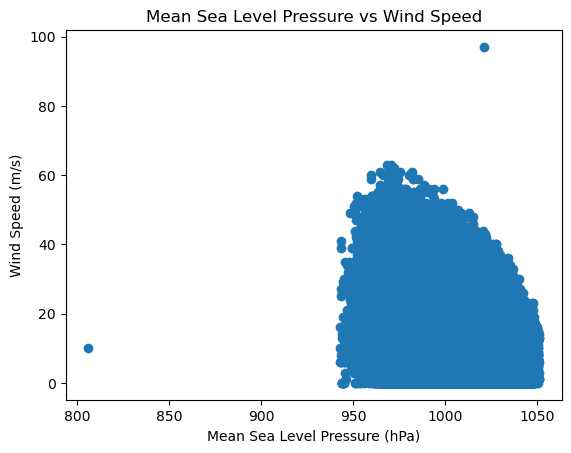

In [13]:
columns_to_use = ['date', 'rain', 'temp', 'wdsp', 'wddir', 'dewpt', 'vappr', 'rhum', 'msl']
subset_data = my_big_dataset[columns_to_use]

plt.scatter(subset_data['msl'], subset_data['wdsp'])
plt.title("Mean Sea Level Pressure vs Wind Speed")
plt.xlabel("Mean Sea Level Pressure (hPa)")
plt.ylabel("Wind Speed (m/s)")
plt.show()


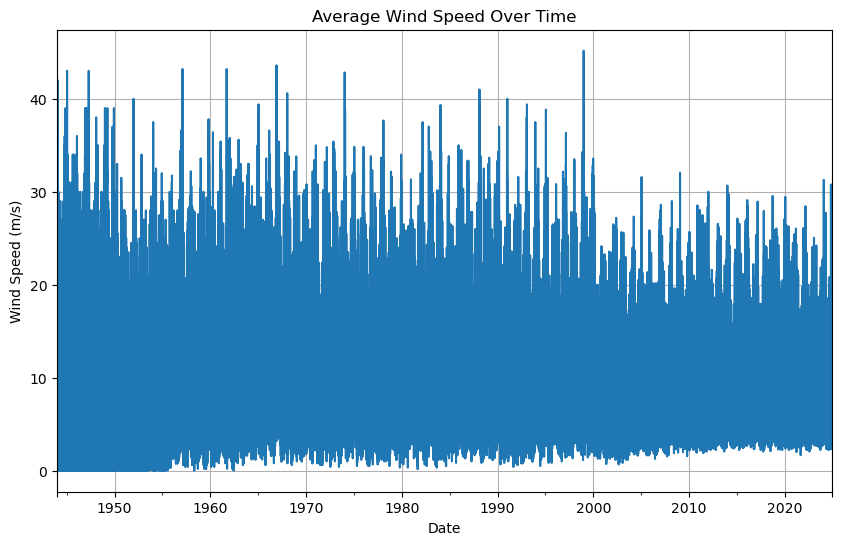

In [14]:
plt.figure(figsize=(10, 6))
subset_data.groupby('date')['wdsp'].mean().plot(kind='line')
plt.title("Average Wind Speed Over Time")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.grid()
plt.show()


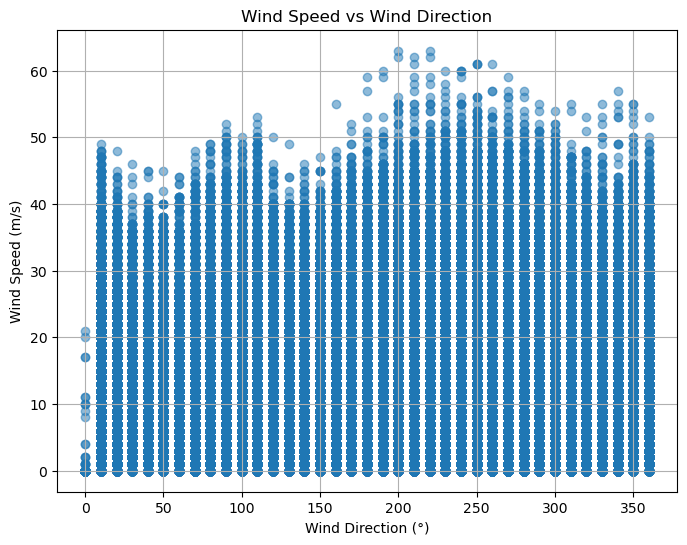

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(subset_data['wddir'], subset_data['wdsp'], alpha=0.5)
plt.title("Wind Speed vs Wind Direction")
plt.xlabel("Wind Direction (°)")
plt.ylabel("Wind Speed (m/s)")
plt.grid()
plt.show()


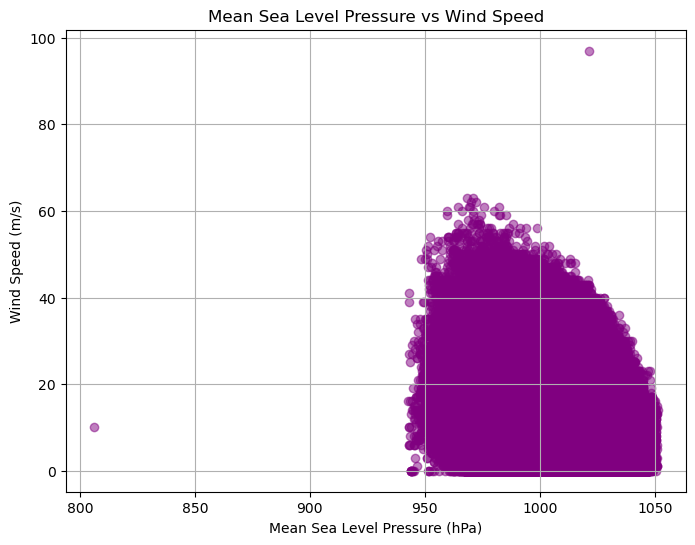

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(subset_data['msl'], subset_data['wdsp'], alpha=0.5, color='purple')
plt.title("Mean Sea Level Pressure vs Wind Speed")
plt.xlabel("Mean Sea Level Pressure (hPa)")
plt.ylabel("Wind Speed (m/s)")
plt.grid()
plt.show()

